# Kernel Method for Finding Invariant Circles

Here, we will show examples of the `kernel_eigs` and `kernel_bvp` functions, which find approximately invariant functions of a symplectic map. To be more specific, let $F : \Omega \to \Omega$ be a symplectic map. An approximately invariant function $h$ is one that satisfies
$$ 
\lVert h\circ F - h \rVert \ll \lVert h \rVert,
$$
for some norm. We find the function $h$ by discretizing it via kernels, i.e. for a positive (semi)definite kernel $K : \Omega \times \Omega \to \mathbb{R}$, we define the kernel function on the data $y_n \in \Omega$ as
$$
h(x) = \sum_{n = 1}^{2N}c_n K(x, y_n).
$$
For the points $y_n$, we first sample a sequence $x_1, x_2, \dots, x_N$ in some domain $U \in \Omega$. Then, we evaluate $F(x_n)$, giving the sequence $y_1 = x_1$, $y_2 = F(x_1)$, $y_3 = x_2$, $y_4 = F(x_2)$, etc.

`SymplecticMapTools` comes equipped with sampling schemes for rectangular domains. Consider the symplectic map:

In [1]:
using SymplecticMapTools
using CairoMakie
using LinearAlgebra

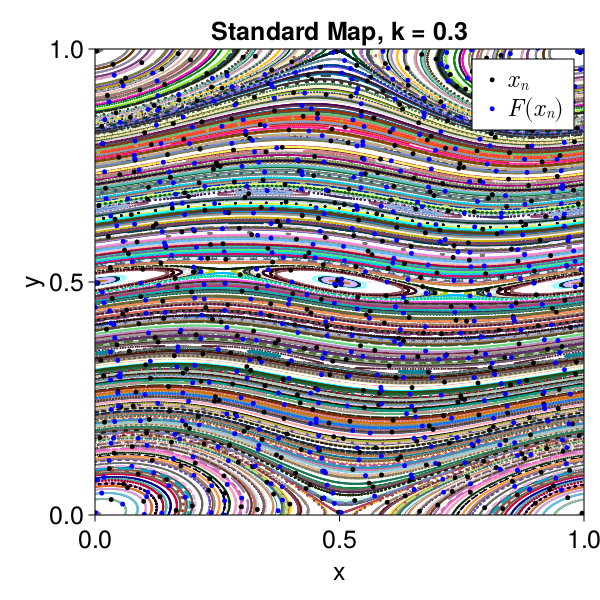

In [2]:
k_sm = 0.3;
F = standard_map_F(k_sm);

N = 500
xb = [0., 1.]
yb = [0., 1.]
xs = kernel_sample_F(F, N, xb, yb);
ylims = yb
f, xs_pp = poincare_plot([0,1], [0,1], F, N, 500; title="Standard Map, k = $(k_sm)", ylims, resolution=(600, 600))
ax = contents(f[1, 1])
plot!(xs[1,1:2:end], xs[2,1:2:end], color=:black, markersize=7, label=L"x_n")
plot!(xs[1,2:2:end], xs[2,2:2:end], color=:blue, markersize=7, label=L"F(x_n)")
axislegend()

f

Above is a Poincare plot of the standard map with $k = 0.3$, along with the points $y_n$ used for the kernel method. Now, to apply the method, we also need weights for boundary conditions $w_{\mathrm{bd}}:\Omega \to \mathbb{R}$. The boundary condition weight function should be equal to $1$ where you want to enforce boundary conditions, and $0$ where you do not. It is typically best for it to be chosen smooth in between as well. One good option for this is to use a sum of logistic functions. A simple version of this is implemented in `window_weight` for maps in $\mathbb{T} \times \mathbb{R}$ and `rectangular_window_weight` for maps in $\mathbb{R}^2$:

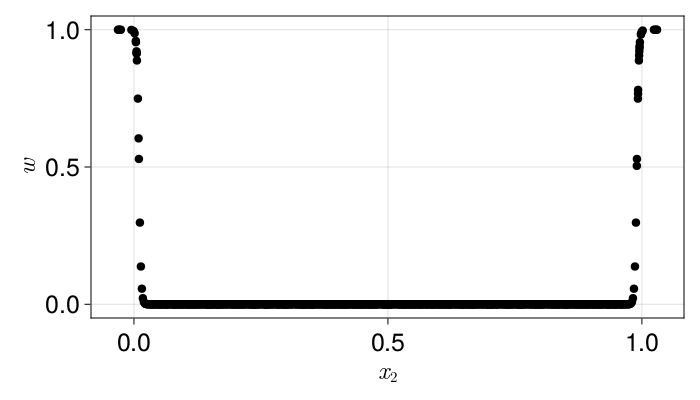

In [3]:
lims = [0.01, 0.99]; # window size, includes the boundaries
α = 0.002;           # Transition length scale
w = window_weight(xs, lims, α)

resolution = (700, 400); fontsize=25;
f = Figure(;resolution, fontsize)
ax = Axis(f[1,1], xlabel=L"x_2", ylabel=L"w")
plot!(xs[2, :], w)

f

Above shows how the weighting applys to the vertical component. We see we are applying our boundary conditions at the top and bottom, but not in the interior. Now, we have enough information to call `kernel_eigs` to find an approximately invariant function. It does this by minimizing the following Rayleigh quotient:
$$
\lambda = \min_c \frac{ E_{\mathrm{Inv}} + E_{\mathrm{bd}} + E_{\mathrm{K}} }{E_{L^2}},
$$
where
$$ 
E_{\mathrm{Inv}} = \sum_{n = 1}^N (h(y_{2n-1}) - h(y_{2n}))^2 = \sum_{n = 1}^N (h(x_n) - h(F(x_n)))^2
$$
is an energy that forces $h$ to be approximately invariant,
$$ 
E_{\mathrm{bd}} = \sum_{n=1}^{2N} w_{\mathrm{bd}}(y_n) h(y_n)^2 
$$
is the a penalty on nonzero boundary conditions, 
$$
E_{\mathrm{K}} = \sum_{n, m = 1}^{2N} K(y_n, y_m) c_n c_m
$$
is a kernel norm encouraging smooth solutions, and
$$
E_{L^2} = \sum_{n = 1}^{2N} h(y_n)^2
$$
is the $L^2$ norm of the function. We note that the eigenvalue problem is useful to get a nonzero solution (simply minimizing the numerator would give $h = 0$ regardless of the map, a decidedly unhelpful function). 

We can see an output approximately invariant function in the following block:

The returned eigenvalue is λ = 1.3282212073932726e-7


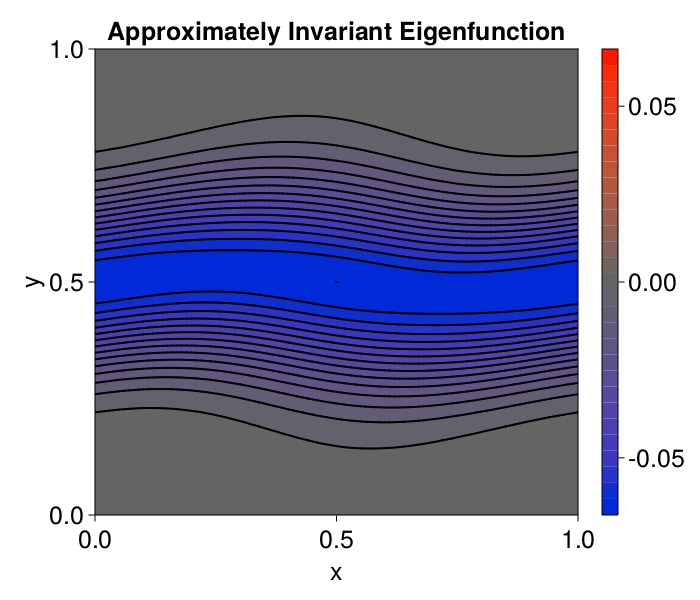

In [4]:
ϵ = 1e-8 # Weight of regularization. Should be small and nonzero
nev = 1  # Number of eigenvalues/eigenvectors to find
σ = 0.25 # Length scale of the kernel
kernel = :FourierSE # Product kernel that is periodic sine squared exponential in x and squared exponential in y

λs, vs, k = kernel_eigs(xs, ϵ, nev, σ, w; kernel)
println("The returned eigenvalue is λ = $(λs[1])")
f, f_grid = plot_on_grid(0:0.01:1, 0:0.01:1, k; levels=30, resolution=(700, 600), 
                         xlabel="x", ylabel="y", title="Approximately Invariant Eigenfunction")
f

Qualitatively, we see the contours of the label function matches the Poincare plot well. Additionally, the value of $\lambda$ tells us that $E_{\mathrm{Inv}} \ll E_{L^2}$, which is the discretization of our definition of an approximately invariant function.

We can find such a plot without an eigenvalue solve as well using a boundary value problem. For this, we require a boundary value function $h_{\mathrm{bd}} : \Omega \to \mathbb{R}$. Given this, the boundary value problem is phrased as
$$
R = \min_c (E_{\mathrm{Inv}} + E_{\mathrm{bd,h}} + \epsilon E_{\mathrm{K}}),
$$
where
$$ 
E_{\mathrm{bd, h}} = \sum_{n=1}^{2N} w_{\mathrm{bd}}(y_n) (h(y_n) - h_{\mathrm{bd}}(y_n))^2 
$$
is the new boundary condition energy. The boundary values give a different method by which the label function is forced to be nonzero. Typically, the boundary value problem is useful when you want to know if circles foliate a certain annulus. 

We can apply this method using the function `kernel_bvp`:

R     = 7.280189878646064e-5, 
E_bd  = 6.430302463331248e-6, 
E_inv = 4.242327130578215e-5, 
E_K   = 2.3948325017347242e-5,
E_L2  = 519.65349415868


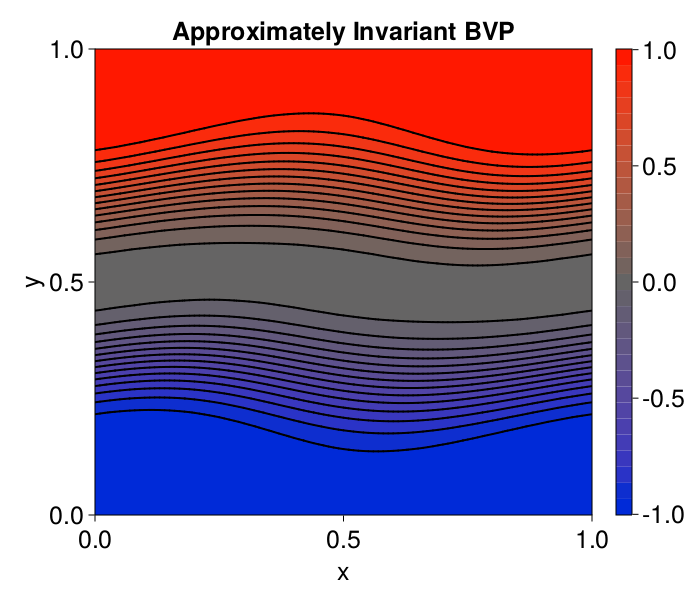

In [5]:
hbd = [xi[2] > 0.5 ? 1. : -1. for xi = eachcol(xs)]
k, R, E_bd, E_inv, E_K = kernel_bvp(xs, ϵ, σ, w, hbd; kernel)
hs = evaluate(k, xs)
println("R     = $R, 
E_bd  = $(E_bd), 
E_inv = $(E_inv), 
E_K   = $(E_K),
E_L2  = $(hs'*hs)")
f, f_grid = plot_on_grid(0:0.01:1, 0:0.01:1, k; levels=30, resolution=(700, 600), 
                         xlabel="x", ylabel="y", title="Approximately Invariant BVP")
f

Again, we see a very similar invariant function, with $E_{\mathrm{Inv}} \ll E_{L^2}$. 